In [70]:
import os, tarfile, math
import pyBigWig
import pybedtools
import zipfile, gzip
from gtfparse import read_gtf
import pandas as pd
pd.set_option('display.max_columns', None)
from Bio import SeqIO
import pandas as pd
import numpy as np
import re 
from collections import Counter
from itertools import product
from collections import Counter

In [2]:
gtf_file_path = "/data/projects/Resources/Gencode_genome_annotation/gencode.v40.annotation.gtf"

In [3]:
def parse_attributes(attribute_string):
    # Split each attribute into key and value, then strip quotes and spaces
    return dict(item.strip().replace('"', '').split(' ') for item in attribute_string if item)

In [4]:
column_names = [
    "seqname", "source", "feature", "start", "end",
    "score", "strand", "frame", "attribute"
]

# Read the GTF file
gtf_df = pd.read_csv(gtf_file_path, sep="\t", comment='#', header=None, names=column_names)

In [5]:
# Step 1: Split the 'attribute' string into a list of strings for each key-value pair
attributes_list = gtf_df['attribute'].str.split(';')


# Apply the function to each row's attribute list
attributes_dicts = attributes_list.apply(parse_attributes)

# Step 3: Convert the list of dictionaries into a DataFrame
attributes_df = pd.DataFrame(list(attributes_dicts))

# Step 4: Combine the new attributes DataFrame with the original gtf_df
# This step assumes that the indexes are aligned and can be directly concatenated
combined_df = pd.concat([gtf_df, attributes_df], axis=1)

# Optionally, you can drop the original 'attribute' column if it's no longer needed
combined_df = combined_df.drop('attribute', axis=1)

In [6]:
combined_df

,seqname,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,level,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
0,chr1,HAVANA,gene,11869,14409,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,HAVANA,transcript,11869,14409,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,NaN,NaN,NaN,NaN,NaN
2,chr1,HAVANA,exon,11869,12227,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,1,ENSE00002234944.1,NaN,NaN,NaN
3,chr1,HAVANA,exon,12613,12721,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,2,ENSE00003582793.1,NaN,NaN,NaN
4,chr1,HAVANA,exon,13221,14409,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,3,ENSE00002312635.1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283857,chrM,ENSEMBL,transcript,15888,15953,.,+,.,ENSG00000210195.2,Mt_tRNA,MT-TT,3,HGNC:7499,NaN,ENST00000387460.2,Mt_tRNA,MT-TT-201,NA,Ensembl_canonical,NaN,NaN,NaN,NaN,NaN,NaN
3283858,chrM,ENSEMBL,exon,15888,15953,.,+,.,ENSG00000210195.2,Mt_tRNA,MT-TT,3,HGNC:7499,NaN,ENST00000387460.2,Mt_tRNA,MT-TT-201,NA,Ensembl_canonical,NaN,1,ENSE00001544475.2,NaN,NaN,NaN
3283859,chrM,ENSEMBL,gene,15956,16023,.,-,.,ENSG00000210196.2,Mt_tRNA,MT-TP,3,HGNC:7494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3283860,chrM,ENSEMBL,transcript,15956,16023,.,-,.,ENSG00000210196.2,Mt_tRNA,MT-TP,3,HGNC:7494,NaN,ENST00000387461.2,Mt_tRNA,MT-TP-201,NA,Ensembl_canonical,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_gene = combined_df[combined_df["feature"] == "gene"]
df_gene

,seqname,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,level,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
0,chr1,HAVANA,gene,11869,14409,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,chr1,HAVANA,gene,14404,29570,.,-,.,ENSG00000227232.5,unprocessed_pseudogene,WASH7P,2,HGNC:38034,OTTHUMG00000000958.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,chr1,ENSEMBL,gene,17369,17436,.,-,.,ENSG00000278267.1,miRNA,MIR6859-1,3,HGNC:50039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,chr1,HAVANA,gene,29554,31109,.,+,.,ENSG00000243485.5,lncRNA,MIR1302-2HG,2,HGNC:52482,OTTHUMG00000000959.2,NaN,NaN,NaN,NaN,ncRNA_host,NaN,NaN,NaN,NaN,NaN,NaN
36,chr1,ENSEMBL,gene,30366,30503,.,+,.,ENSG00000284332.1,miRNA,MIR1302-2,3,HGNC:35294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283843,chrM,ENSEMBL,gene,14149,14673,.,-,.,ENSG00000198695.2,protein_coding,MT-ND6,3,HGNC:7462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3283848,chrM,ENSEMBL,gene,14674,14742,.,-,.,ENSG00000210194.1,Mt_tRNA,MT-TE,3,HGNC:7479,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3283851,chrM,ENSEMBL,gene,14747,15887,.,+,.,ENSG00000198727.2,protein_coding,MT-CYB,3,HGNC:7427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3283856,chrM,ENSEMBL,gene,15888,15953,.,+,.,ENSG00000210195.2,Mt_tRNA,MT-TT,3,HGNC:7499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_gene.groupby('gene_type').size()

gene_type
IG_C_gene                                14
IG_C_pseudogene                           9
IG_D_gene                                37
IG_J_gene                                18
IG_J_pseudogene                           3
IG_V_gene                               145
IG_V_pseudogene                         187
IG_pseudogene                             1
Mt_rRNA                                   2
Mt_tRNA                                  22
TEC                                    1057
TR_C_gene                                 6
TR_D_gene                                 4
TR_J_gene                                79
TR_J_pseudogene                           4
TR_V_gene                               106
TR_V_pseudogene                          33
lncRNA                                17748
miRNA                                  1879
misc_RNA                               2212
polymorphic_pseudogene                   50
processed_pseudogene                  10154
protein_coding        

In [9]:
df_gene[df_gene['gene_type']=="protein_coding"]

,seqname,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,level,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
57,chr1,HAVANA,gene,65419,71585,.,+,.,ENSG00000186092.7,protein_coding,OR4F5,2,HGNC:14825,OTTHUMG00000001094.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
319,chr1,HAVANA,gene,450740,451678,.,-,.,ENSG00000284733.2,protein_coding,OR4F29,2,HGNC:31275,OTTHUMG00000002860.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
446,chr1,HAVANA,gene,685716,686654,.,-,.,ENSG00000284662.2,protein_coding,OR4F16,2,HGNC:15079,OTTHUMG00000002581.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,chr1,HAVANA,gene,923923,944575,.,+,.,ENSG00000187634.13,protein_coding,SAMD11,2,HGNC:28706,OTTHUMG00000040719.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1245,chr1,HAVANA,gene,944203,959309,.,-,.,ENSG00000188976.11,protein_coding,NOC2L,2,HGNC:24517,OTTHUMG00000040720.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283816,chrM,ENSEMBL,gene,10470,10766,.,+,.,ENSG00000212907.2,protein_coding,MT-ND4L,3,HGNC:7460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3283823,chrM,ENSEMBL,gene,10760,12137,.,+,.,ENSG00000198886.2,protein_coding,MT-ND4,3,HGNC:7459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3283837,chrM,ENSEMBL,gene,12337,14148,.,+,.,ENSG00000198786.2,protein_coding,MT-ND5,3,HGNC:7461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3283843,chrM,ENSEMBL,gene,14149,14673,.,-,.,ENSG00000198695.2,protein_coding,MT-ND6,3,HGNC:7462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
combined_df[combined_df["feature"] == "transcript"]

,seqname,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,level,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
1,chr1,HAVANA,transcript,11869,14409,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,NaN,NaN,NaN,NaN,NaN
5,chr1,HAVANA,transcript,12010,13670,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000450305.2,transcribed_unprocessed_pseudogene,DDX11L1-201,NA,Ensembl_canonical,OTTHUMT00000002844.2,NaN,NaN,PGO:0000019,NaN,NaN
13,chr1,HAVANA,transcript,14404,29570,.,-,.,ENSG00000227232.5,unprocessed_pseudogene,WASH7P,2,HGNC:38034,OTTHUMG00000000958.1,ENST00000488147.1,unprocessed_pseudogene,WASH7P-201,NA,Ensembl_canonical,OTTHUMT00000002839.1,NaN,NaN,PGO:0000005,NaN,NaN
26,chr1,ENSEMBL,transcript,17369,17436,.,-,.,ENSG00000278267.1,miRNA,MIR6859-1,3,HGNC:50039,NaN,ENST00000619216.1,miRNA,MIR6859-1-201,NA,Ensembl_canonical,NaN,NaN,NaN,NaN,NaN,NaN
29,chr1,HAVANA,transcript,29554,31097,.,+,.,ENSG00000243485.5,lncRNA,MIR1302-2HG,2,HGNC:52482,OTTHUMG00000000959.2,ENST00000473358.1,lncRNA,MIR1302-2HG-202,5,Ensembl_canonical,OTTHUMT00000002840.1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283844,chrM,ENSEMBL,transcript,14149,14673,.,-,.,ENSG00000198695.2,protein_coding,MT-ND6,3,HGNC:7462,NaN,ENST00000361681.2,protein_coding,MT-ND6-201,NA,appris_principal_1,NaN,NaN,NaN,NaN,ENSP00000354665.2,NaN
3283849,chrM,ENSEMBL,transcript,14674,14742,.,-,.,ENSG00000210194.1,Mt_tRNA,MT-TE,3,HGNC:7479,NaN,ENST00000387459.1,Mt_tRNA,MT-TE-201,NA,Ensembl_canonical,NaN,NaN,NaN,NaN,NaN,NaN
3283852,chrM,ENSEMBL,transcript,14747,15887,.,+,.,ENSG00000198727.2,protein_coding,MT-CYB,3,HGNC:7427,NaN,ENST00000361789.2,protein_coding,MT-CYB-201,NA,appris_principal_1,NaN,NaN,NaN,NaN,ENSP00000354554.2,NaN
3283857,chrM,ENSEMBL,transcript,15888,15953,.,+,.,ENSG00000210195.2,Mt_tRNA,MT-TT,3,HGNC:7499,NaN,ENST00000387460.2,Mt_tRNA,MT-TT-201,NA,Ensembl_canonical,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Filter rows where 'feature' is 'transcript' and 'seqname' is not 'chrM'
gtf_transcript = combined_df[(combined_df["feature"] == "transcript") & (combined_df["seqname"] != "chrM")]

# Display the resulting DataFrame
gtf_transcript

,seqname,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,level,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
1,chr1,HAVANA,transcript,11869,14409,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,NaN,NaN,NaN,NaN,NaN
5,chr1,HAVANA,transcript,12010,13670,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000450305.2,transcribed_unprocessed_pseudogene,DDX11L1-201,NA,Ensembl_canonical,OTTHUMT00000002844.2,NaN,NaN,PGO:0000019,NaN,NaN
13,chr1,HAVANA,transcript,14404,29570,.,-,.,ENSG00000227232.5,unprocessed_pseudogene,WASH7P,2,HGNC:38034,OTTHUMG00000000958.1,ENST00000488147.1,unprocessed_pseudogene,WASH7P-201,NA,Ensembl_canonical,OTTHUMT00000002839.1,NaN,NaN,PGO:0000005,NaN,NaN
26,chr1,ENSEMBL,transcript,17369,17436,.,-,.,ENSG00000278267.1,miRNA,MIR6859-1,3,HGNC:50039,NaN,ENST00000619216.1,miRNA,MIR6859-1-201,NA,Ensembl_canonical,NaN,NaN,NaN,NaN,NaN,NaN
29,chr1,HAVANA,transcript,29554,31097,.,+,.,ENSG00000243485.5,lncRNA,MIR1302-2HG,2,HGNC:52482,OTTHUMG00000000959.2,ENST00000473358.1,lncRNA,MIR1302-2HG-202,5,Ensembl_canonical,OTTHUMT00000002840.1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283698,chrY,HAVANA,transcript,57209306,57210051,.,+,.,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,2,HGNC:31685,OTTHUMG00000022677.5,ENST00000483079.6_PAR_Y,retained_intron,WASH6P-210,1,PAR,OTTHUMT00000058833.1,NaN,NaN,NaN,NaN,NaN
3283701,chrY,HAVANA,transcript,57209887,57212186,.,+,.,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,2,HGNC:31685,OTTHUMG00000022677.5,ENST00000496301.6_PAR_Y,retained_intron,WASH6P-215,2,PAR,OTTHUMT00000058827.1,NaN,NaN,NaN,NaN,NaN
3283704,chrY,HAVANA,transcript,57210344,57212074,.,+,.,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,2,HGNC:31685,OTTHUMG00000022677.5,ENST00000483286.6_PAR_Y,retained_intron,WASH6P-211,1,PAR,OTTHUMT00000058834.1,NaN,NaN,NaN,NaN,NaN
3283708,chrY,HAVANA,transcript,57210591,57212074,.,+,.,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,2,HGNC:31685,OTTHUMG00000022677.5,ENST00000464205.6_PAR_Y,processed_transcript,WASH6P-205,2,PAR,OTTHUMT00000058835.1,NaN,NaN,NaN,NaN,NaN


In [12]:
gtf_transcript.groupby('transcript_type').size()

transcript_type
IG_C_gene                                23
IG_C_pseudogene                           9
IG_D_gene                                37
IG_J_gene                                18
IG_J_pseudogene                           3
IG_V_gene                               145
IG_V_pseudogene                         187
IG_pseudogene                             1
TEC                                    1147
TR_C_gene                                 6
TR_D_gene                                 4
TR_J_gene                                79
TR_J_pseudogene                           4
TR_V_gene                               106
TR_V_pseudogene                          33
lncRNA                                51324
miRNA                                  1879
misc_RNA                               2212
non_stop_decay                           99
nonsense_mediated_decay               20254
polymorphic_pseudogene                   71
processed_pseudogene                  10156
processed_transc

In [13]:
def extract_tss_regions_from_df(tss_df):
    """
    Extracts TSS (+50 and -50 bp) regions from the GTF DataFrame.
    :param df: A pandas DataFrame containing GTF data.
    :return: A DataFrame with TSS regions.
    """

    # Calculate TSS based on strand
    tss_df['TSS'] = tss_df.apply(lambda x: x['start'] if x['strand'] == '+' else x['end'], axis=1)

    # Adjust TSS based on strand for +50 and -50 bp
    tss_df['start_adj'] = tss_df.apply(lambda x: x['TSS'] - 45 if x['strand'] == '+' else x['TSS'], axis=1)
    tss_df['end_adj'] = tss_df.apply(lambda x: x['TSS'] + 45 if x['strand'] == '+' else x['TSS'] + 90, axis=1)

    # Select and rename relevant columns
    tss_regions = tss_df[['seqname', 'TSS','start_adj', 'end_adj', 'strand', 'gene_id', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name']]
    tss_regions.columns = ['Chromosome', 'TSS', '45BP_Start', '45BP_End', 'Strand', 'GeneID', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name']

    return tss_regions

In [14]:
tss_regions_df = extract_tss_regions_from_df(gtf_transcript)

/tmp/ipykernel_1319166/905394969.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tss_df['TSS'] = tss_df.apply(lambda x: x['start'] if x['strand'] == '+' else x['end'], axis=1)
/tmp/ipykernel_1319166/905394969.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tss_df['start_adj'] = tss_df.apply(lambda x: x['TSS'] - 45 if x['strand'] == '+' else x['TSS'], axis=1)
/tmp/ipykernel_1319166/905394969.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [15]:
tss_regions_df

,Chromosome,TSS,45BP_Start,45BP_End,Strand,GeneID,gene_type,gene_name,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name
1,chr1,11869,11824,11914,+,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202
5,chr1,12010,11965,12055,+,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,HGNC:37102,OTTHUMG00000000961.2,ENST00000450305.2,transcribed_unprocessed_pseudogene,DDX11L1-201
13,chr1,29570,29570,29660,-,ENSG00000227232.5,unprocessed_pseudogene,WASH7P,HGNC:38034,OTTHUMG00000000958.1,ENST00000488147.1,unprocessed_pseudogene,WASH7P-201
26,chr1,17436,17436,17526,-,ENSG00000278267.1,miRNA,MIR6859-1,HGNC:50039,NaN,ENST00000619216.1,miRNA,MIR6859-1-201
29,chr1,29554,29509,29599,+,ENSG00000243485.5,lncRNA,MIR1302-2HG,HGNC:52482,OTTHUMG00000000959.2,ENST00000473358.1,lncRNA,MIR1302-2HG-202
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283698,chrY,57209306,57209261,57209351,+,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000483079.6_PAR_Y,retained_intron,WASH6P-210
3283701,chrY,57209887,57209842,57209932,+,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000496301.6_PAR_Y,retained_intron,WASH6P-215
3283704,chrY,57210344,57210299,57210389,+,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000483286.6_PAR_Y,retained_intron,WASH6P-211
3283708,chrY,57210591,57210546,57210636,+,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000464205.6_PAR_Y,processed_transcript,WASH6P-205


In [16]:
tss_regions_df[['Chromosome','TSS', '45BP_Start', '45BP_End', "Strand"]].drop_duplicates()

,Chromosome,TSS,45BP_Start,45BP_End,Strand
1,chr1,11869,11824,11914,+
5,chr1,12010,11965,12055,+
13,chr1,29570,29570,29660,-
26,chr1,17436,17436,17526,-
29,chr1,29554,29509,29599,+
...,...,...,...,...,...
3283698,chrY,57209306,57209261,57209351,+
3283701,chrY,57209887,57209842,57209932,+
3283704,chrY,57210344,57210299,57210389,+
3283708,chrY,57210591,57210546,57210636,+


In [17]:
# Define a custom aggregation function
def custom_agg(series):
    # If all values are the same, return any one of them; otherwise, return the list of unique values
    if series.nunique() == 1:
        return series.iloc[0]
    else:
        return list(series.unique())

In [18]:
# Group by the columns 'Chromosome', 'Start', 'End', 'Strand'
# and aggregate other columns
unique_tss_df = tss_regions_df.groupby(['Chromosome','TSS', '45BP_Start', '45BP_End', "Strand"]).agg(custom_agg).reset_index()

In [19]:
unique_tss_df

,Chromosome,TSS,45BP_Start,45BP_End,Strand,GeneID,gene_type,gene_name,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name
0,chr1,11869,11824,11914,+,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202
1,chr1,12010,11965,12055,+,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,HGNC:37102,OTTHUMG00000000961.2,ENST00000450305.2,transcribed_unprocessed_pseudogene,DDX11L1-201
2,chr1,17436,17436,17526,-,ENSG00000278267.1,miRNA,MIR6859-1,HGNC:50039,[nan],ENST00000619216.1,miRNA,MIR6859-1-201
3,chr1,29554,29509,29599,+,ENSG00000243485.5,lncRNA,MIR1302-2HG,HGNC:52482,OTTHUMG00000000959.2,ENST00000473358.1,lncRNA,MIR1302-2HG-202
4,chr1,29570,29570,29660,-,ENSG00000227232.5,unprocessed_pseudogene,WASH7P,HGNC:38034,OTTHUMG00000000958.1,ENST00000488147.1,unprocessed_pseudogene,WASH7P-201
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215293,chrY,57209306,57209261,57209351,+,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000483079.6_PAR_Y,retained_intron,WASH6P-210
215294,chrY,57209887,57209842,57209932,+,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000496301.6_PAR_Y,retained_intron,WASH6P-215
215295,chrY,57210344,57210299,57210389,+,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000483286.6_PAR_Y,retained_intron,WASH6P-211
215296,chrY,57210591,57210546,57210636,+,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000464205.6_PAR_Y,processed_transcript,WASH6P-205


In [20]:
def read_genome(fasta_file):
    """
    Reads a genome fasta file and returns a dictionary of chromosomes and sequences.
    :param fasta_file: Path to the genome fasta file.
    :return: A dictionary with chromosome names as keys and sequences as values.
    """
    genome = {}
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        genome[seq_record.id] = seq_record.seq
    return genome

def fetch_sequences_for_regions(df, genome):
    """
    Fetches sequences for regions specified in the DataFrame from the genome.
    :param df: DataFrame with the regions (must contain 'Chromosome', 'Start', 'End', and 'Strand' columns).
    :param genome: Dictionary of genome sequences.
    :return: List of sequences corresponding to the regions.
    """
    sequences = []
    for index, row in df.iterrows():
        # Extracting the sequence
        seq = genome[row['Chromosome']][row['45BP_Start']:row['45BP_End']]
        
        # Reverse complement if the gene is on the negative strand
        if row['Strand'] == '-':
            seq = seq.reverse_complement()
        seq= seq.upper()
        
        sequences.append(str(seq))  # Converts Seq object to string
    return sequences

In [21]:
# Paths
genome_path = "/data/projects/Resources/Gencode_genome_annotation/GRCh38.primary_assembly.genome.fa"
# Load the genome and TSS regions
genome = read_genome(genome_path)
# Fetch sequences
sequences = fetch_sequences_for_regions(unique_tss_df, genome)

In [22]:
unique_tss_df['Sequence'] = sequences  # Add sequences to the DataFrame
unique_tss_df

,Chromosome,TSS,45BP_Start,45BP_End,Strand,GeneID,gene_type,gene_name,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,Sequence
0,chr1,11869,11824,11914,+,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202,AACGAGATTGCCAGCACCGGGTATCATTCACCATTTTTCTTTTCGT...
1,chr1,12010,11965,12055,+,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,HGNC:37102,OTTHUMG00000000961.2,ENST00000450305.2,transcribed_unprocessed_pseudogene,DDX11L1-201,TTTGAGAGGTCACAGGGTCTTGATGCTGTGGTCTTCATCTGCAGGT...
2,chr1,17436,17436,17526,-,ENSG00000278267.1,miRNA,MIR6859-1,HGNC:50039,[nan],ENST00000619216.1,miRNA,MIR6859-1-201,GGTACAGCACATAGGCCAGGAGCCAGGGGGTGACGGGTGGCTCGGC...
3,chr1,29554,29509,29599,+,ENSG00000243485.5,lncRNA,MIR1302-2HG,HGNC:52482,OTTHUMG00000000959.2,ENST00000473358.1,lncRNA,MIR1302-2HG-202,CGCGGGCCTGGGCACGGAACTCACGCTCACTCCGAGCTCCCGACGT...
4,chr1,29570,29570,29660,-,ENSG00000227232.5,unprocessed_pseudogene,WASH7P,HGNC:38034,OTTHUMG00000000958.1,ENST00000488147.1,unprocessed_pseudogene,WASH7P-201,CAGCGATGGGACAAAGGACGGAGGTCTAGGAAGAGGGTCTGCAGAG...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215293,chrY,57209306,57209261,57209351,+,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000483079.6_PAR_Y,retained_intron,WASH6P-210,ACAAAGACCCATGTGATGCTGGGGGCAGAGACAGAGGAGAAGCTGT...
215294,chrY,57209887,57209842,57209932,+,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000496301.6_PAR_Y,retained_intron,WASH6P-215,CACCACCCCCACCGCCCCCACCACCACCCCCAGCTCCTGAGGTGCT...
215295,chrY,57210344,57210299,57210389,+,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000483286.6_PAR_Y,retained_intron,WASH6P-211,TAACCCTAGCATCCAGAAGTGGCACAAAACCCCTCTGCTGGCTCAT...
215296,chrY,57210591,57210546,57210636,+,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000464205.6_PAR_Y,processed_transcript,WASH6P-205,TCCCTCCCAGCAGGCTCTTGGACACAGTAAGCTTCCCCAGCCCTGC...


In [23]:
unique_tss_df = unique_tss_df[~unique_tss_df['Sequence'].str.contains('N')]
unique_tss_df

,Chromosome,TSS,45BP_Start,45BP_End,Strand,GeneID,gene_type,gene_name,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,Sequence
0,chr1,11869,11824,11914,+,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202,AACGAGATTGCCAGCACCGGGTATCATTCACCATTTTTCTTTTCGT...
1,chr1,12010,11965,12055,+,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,HGNC:37102,OTTHUMG00000000961.2,ENST00000450305.2,transcribed_unprocessed_pseudogene,DDX11L1-201,TTTGAGAGGTCACAGGGTCTTGATGCTGTGGTCTTCATCTGCAGGT...
2,chr1,17436,17436,17526,-,ENSG00000278267.1,miRNA,MIR6859-1,HGNC:50039,[nan],ENST00000619216.1,miRNA,MIR6859-1-201,GGTACAGCACATAGGCCAGGAGCCAGGGGGTGACGGGTGGCTCGGC...
3,chr1,29554,29509,29599,+,ENSG00000243485.5,lncRNA,MIR1302-2HG,HGNC:52482,OTTHUMG00000000959.2,ENST00000473358.1,lncRNA,MIR1302-2HG-202,CGCGGGCCTGGGCACGGAACTCACGCTCACTCCGAGCTCCCGACGT...
4,chr1,29570,29570,29660,-,ENSG00000227232.5,unprocessed_pseudogene,WASH7P,HGNC:38034,OTTHUMG00000000958.1,ENST00000488147.1,unprocessed_pseudogene,WASH7P-201,CAGCGATGGGACAAAGGACGGAGGTCTAGGAAGAGGGTCTGCAGAG...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215293,chrY,57209306,57209261,57209351,+,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000483079.6_PAR_Y,retained_intron,WASH6P-210,ACAAAGACCCATGTGATGCTGGGGGCAGAGACAGAGGAGAAGCTGT...
215294,chrY,57209887,57209842,57209932,+,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000496301.6_PAR_Y,retained_intron,WASH6P-215,CACCACCCCCACCGCCCCCACCACCACCCCCAGCTCCTGAGGTGCT...
215295,chrY,57210344,57210299,57210389,+,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000483286.6_PAR_Y,retained_intron,WASH6P-211,TAACCCTAGCATCCAGAAGTGGCACAAAACCCCTCTGCTGGCTCAT...
215296,chrY,57210591,57210546,57210636,+,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000464205.6_PAR_Y,processed_transcript,WASH6P-205,TCCCTCCCAGCAGGCTCTTGGACACAGTAAGCTTCCCCAGCCCTGC...


## PWM(Position weight matrix) generation

In [24]:
TATA_PFM_file_path = '/home/campus.stonybrook.edu/pdutta/Github/Postdoc/DNABERT_data_processing/Core_promoter/POL012.1.pfm'

## Creating Position Frequency Matrix(PFM)

In [25]:
# Parsing the PFM data from the text file
pfm = {}
nucleotides = ['A', 'C', 'G', 'T']

with open(TATA_PFM_file_path, 'r') as file:
    pfm_data = file.readlines()[1:]  # Skip the first line (header)

for line in pfm_data:
    parts = line.split()
    nt = parts[0]
    counts = [float(count) for count in parts[1:]]

    if nt in nucleotides:
        for i, count in enumerate(counts):
            if i not in pfm:
                pfm[i] = {}
            pfm[i][nt] = count

In [26]:
pfm

{0: {'A': 61.0, 'C': 145.0, 'G': 152.0, 'T': 31.0},
 1: {'A': 16.0, 'C': 46.0, 'G': 18.0, 'T': 309.0},
 2: {'A': 352.0, 'C': 0.0, 'G': 2.0, 'T': 35.0},
 3: {'A': 3.0, 'C': 10.0, 'G': 2.0, 'T': 374.0},
 4: {'A': 354.0, 'C': 0.0, 'G': 5.0, 'T': 30.0},
 5: {'A': 268.0, 'C': 0.0, 'G': 0.0, 'T': 121.0},
 6: {'A': 360.0, 'C': 3.0, 'G': 10.0, 'T': 6.0},
 7: {'A': 222.0, 'C': 2.0, 'G': 44.0, 'T': 121.0},
 8: {'A': 155.0, 'C': 44.0, 'G': 157.0, 'T': 33.0},
 9: {'A': 56.0, 'C': 135.0, 'G': 150.0, 'T': 48.0},
 10: {'A': 83.0, 'C': 147.0, 'G': 128.0, 'T': 31.0},
 11: {'A': 82.0, 'C': 127.0, 'G': 128.0, 'T': 52.0},
 12: {'A': 82.0, 'C': 118.0, 'G': 128.0, 'T': 61.0},
 13: {'A': 68.0, 'C': 107.0, 'G': 139.0, 'T': 75.0},
 14: {'A': 77.0, 'C': 101.0, 'G': 140.0, 'T': 71.0}}

## Creating Position Weight Matrix(PWM)

In [27]:
# Background nucleotide probabilities (assuming equal distribution)
background = {'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25}

# Convert PFM to probabilities and then to PWM (log-likelihood ratios)
pwm = {}
for pos, counts in pfm.items():
    #print(pos, counts)
    total_counts = sum(counts.values())
    #print(total_counts)
    pwm[pos] = {}
    for nt, count in counts.items():
        #print(nt, count)
        probability = (count+ (math.sqrt(total_counts)/4)) / (total_counts+math.sqrt(total_counts))
        #print(probability, background[nt])
        pwm[pos][nt] = np.log2(probability / background[nt])

In [28]:
pwm_df = pd.DataFrame.from_dict(pwm).reset_index(drop=False)
#pwm_df.reset_index(inplace=True)
pwm_df = pwm_df.set_index('index')

# Transpose DataFrame to make columns as positions and rows as nucleotides
pwm_df = pwm_df.T
pwm_df

index,A,C,G,T
0,-0.632100,0.553173,0.619005,-1.507832
1,-2.287426,-1.004514,-2.155767,1.619323
2,1.804521,-4.373167,-3.881964,-1.355551
3,-3.687519,-2.774763,-3.881964,1.890811
4,1.812582,-4.373167,-3.363074,-1.548553
5,1.417411,-4.373167,-4.373167,0.301507
6,1.872907,-3.662510,-2.744280,-3.196441
7,1.151129,-3.881964,-1.062310,0.301507
8,0.646324,-1.062310,0.664253,-1.429683
9,-0.745881,0.453590,0.600500,-0.948945


In [29]:
len(pwm_df)

15

In [30]:
def calculate_relative_score(pwm_df ,sequence, start_range, end_range):
    best_score = 0  # Initialize with a very low score
    best_position = None
    for i in range(start_range, end_range + 1 - len(pwm_df)):  # Adjust range for segment length
        segment = sequence[i:i + len(pwm_df)]
        #print(segment)
        if len(segment) != len(pwm_df):
            raise ValueError("Sequence length must match PWM length")
        absolute_score = sum(pwm_df[nt][pos] for pos, nt in enumerate(segment))
        #print(absolute_score)
        min_possible_score = pwm_df.min(axis=1).sum()
        max_possible_score = pwm_df.max(axis=1).sum()
        relative_score = (absolute_score - min_possible_score) / (max_possible_score - min_possible_score)
        #print(relative_score)
        if relative_score > best_score:
            best_score = relative_score
            best_position = i
        #print(best_score, best_position)
        #input()
    return best_score, best_position

In [31]:
# Apply the function to each sequence in the dataframe
unique_tss_df['Relative_Score'], unique_tss_df['Position'] = zip(*unique_tss_df['Sequence'].apply(
    lambda seq: calculate_relative_score(pwm_df, seq, 0, 90)))

/tmp/ipykernel_1319166/158273465.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_tss_df['Relative_Score'], unique_tss_df['Position'] = zip(*unique_tss_df['Sequence'].apply(
/tmp/ipykernel_1319166/158273465.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_tss_df['Relative_Score'], unique_tss_df['Position'] = zip(*unique_tss_df['Sequence'].apply(


In [65]:
unique_tss_df.to_csv("/data/private/pdutta_new/non_coding_regions/TATA_NonTATA_PWM/best_relative_score.tsv", sep="\t", index= False)

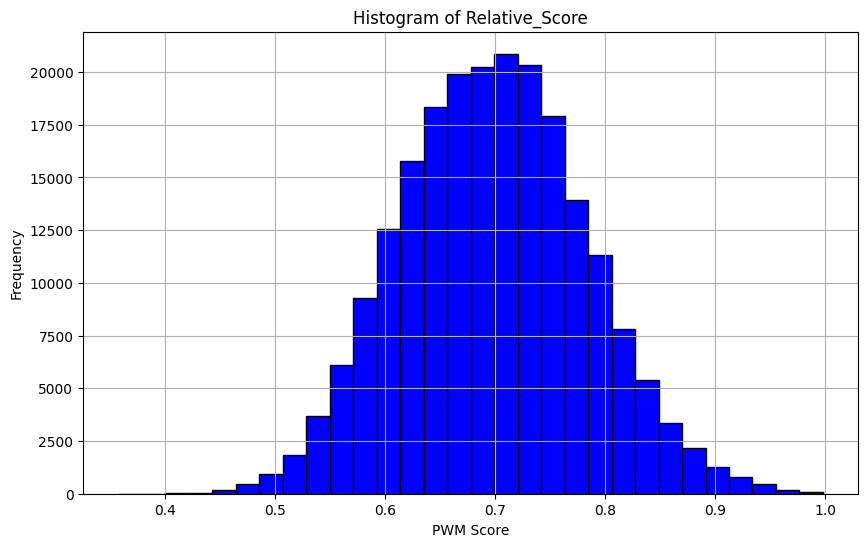

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume unique_tss_df is your DataFrame and PWM_Score is already calculated
# Plotting the distribution of PWM_Score


# # Determine the range of PWM scores
# min_score = unique_tss_df['PWM_Score'].min()
# max_score = unique_tss_df['PWM_Score'].max()

# # Create bins from min to max with each bin covering a range of 5 units
# bins = np.arange(min_score, max_score + 5, 5)  # +5 in max_score for inclusive range on the upper end
# Plotting the histogram
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.hist(unique_tss_df['Relative_Score'], bins=30, color='blue', edgecolor='black')  # Adjust bins as needed
plt.title('Histogram of Relative_Score')  # Title of the histogram
plt.xlabel('PWM Score')  # Label for the x-axis
plt.ylabel('Frequency')  # Label for the y-axis
plt.grid(True)  # Add grid for better visibility of scales
plt.show()

In [86]:
score_threshold = 0.75  # Placeholder value
# Filter dataframe for sequences predicted to contain a TATA core promoter
selected_df = unique_tss_df[unique_tss_df['Relative_Score'] > score_threshold]
selected_df

,Chromosome,TSS,45BP_Start,45BP_End,Strand,GeneID,gene_type,gene_name,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,Sequence,Relative_Score,Position
2,chr1,17436,17436,17526,-,ENSG00000278267.1,miRNA,MIR6859-1,HGNC:50039,[nan],ENST00000619216.1,miRNA,MIR6859-1-201,GGTACAGCACATAGGCCAGGAGCCAGGGGGTGACGGGTGGCTCGGC...,0.757915,6
5,chr1,30267,30222,30312,+,ENSG00000243485.5,lncRNA,MIR1302-2HG,HGNC:52482,OTTHUMG00000000959.2,ENST00000469289.1,lncRNA,MIR1302-2HG-201,AAGAAAAGAGGCTTTTTTAAAAAGTTAAATATATAAAAAGAGCATC...,0.918965,30
6,chr1,30366,30321,30411,+,ENSG00000284332.1,miRNA,MIR1302-2,HGNC:35294,[nan],ENST00000607096.1,miRNA,MIR1302-2-201,GCATTTTTGGCCCTTGCCTTTTAGGGTTGCCAGATTAAAAGACAGG...,0.805204,31
9,chr1,52473,52428,52518,+,ENSG00000268020.3,unprocessed_pseudogene,OR4G4P,HGNC:14822,OTTHUMG00000185779.1,ENST00000606857.1,unprocessed_pseudogene,OR4G4P-201,TCTACTGACTGAGTCAATGGCCAATGGATAGAGTAAATAATTCTGC...,0.763421,32
10,chr1,57598,57553,57643,+,ENSG00000240361.2,transcribed_unprocessed_pseudogene,OR4G11P,HGNC:31276,OTTHUMG00000001095.3,ENST00000642116.1,processed_transcript,OR4G11P-202,TTATATATAGCTTTGTCTTTGGGGTATTACATAAATGAAGATTAAG...,0.857266,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215265,chrY,26549425,26549380,26549470,+,ENSG00000224240.1,processed_pseudogene,CYCSP49,HGNC:23943,OTTHUMG00000036760.1,ENST00000420810.1,processed_pseudogene,CYCSP49-201,AGCGGGAACCTTTGTAGTGCCAGTGATGAAAGAGAGAATTAAATAT...,0.764110,36
215266,chrY,26591601,26591601,26591691,-,ENSG00000227629.1,unprocessed_pseudogene,SLC25A15P1,HGNC:18497,OTTHUMG00000036811.1,ENST00000456738.1,unprocessed_pseudogene,SLC25A15P1-201,TGAAATCTTGCCTCCCCCCAGGGATATGTGGCGCCTGTCATAAGCT...,0.780501,61
215269,chrY,56855244,56855199,56855289,+,ENSG00000235857.1,processed_pseudogene,CTBP2P1,HGNC:23940,OTTHUMG00000036770.1,ENST00000431853.1,processed_pseudogene,CTBP2P1-201,GTACCCTAAAACTTAAAGTATAATAATAATAAAAATAAAAAAAAAG...,0.814299,32
215283,chrY,57190738,57190693,57190783,+,ENSG00000270726.6_PAR_Y,lncRNA,ENSG00000270726,[nan],OTTHUMG00000184987.2,ENST00000483543.7_PAR_Y,retained_intron,ENST00000483543,GCAGACTGTGAAGGAAAGGGAAAGCAAGATTTAGAAACCACCTAGT...,0.754220,28


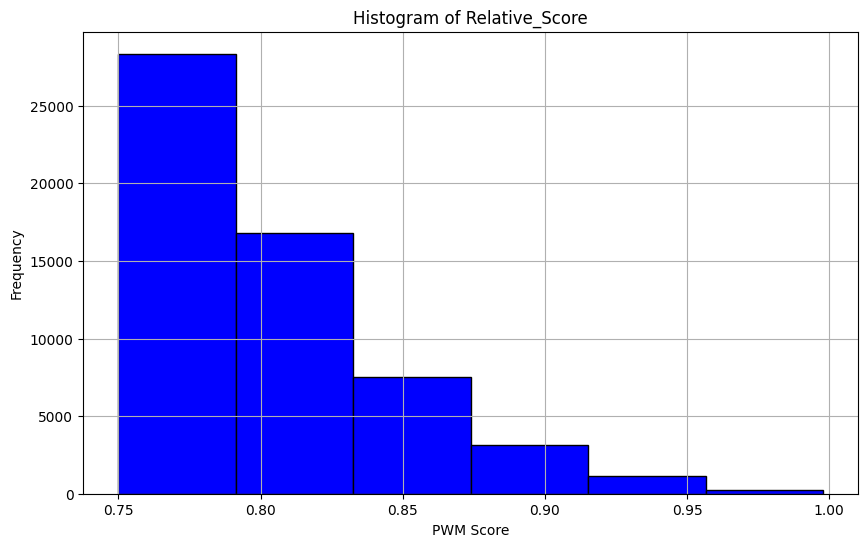

In [87]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.hist(selected_df['Relative_Score'], bins=6, color='blue', edgecolor='black')  # Adjust bins as needed
plt.title('Histogram of Relative_Score')  # Title of the histogram
plt.xlabel('PWM Score')  # Label for the x-axis
plt.ylabel('Frequency')  # Label for the y-axis
plt.grid(True)  # Add grid for better visibility of scales
plt.show()

In [88]:
tata_core_df = selected_df[(selected_df['Position'] >= 10) & (selected_df['Position'] <= 20)]
tata_core_df

,Chromosome,TSS,45BP_Start,45BP_End,Strand,GeneID,gene_type,gene_name,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,Sequence,Relative_Score,Position
25,chr1,157887,157887,157977,-,ENSG00000222623.1,snRNA,RNU6-1100P,HGNC:48063,[nan],ENST00000410691.1,snRNA,RNU6-1100P-201,GCTGTTACTAGGTGCCTATAAATAGCATAGATTTTTAAATTCTCCA...,0.929792,15
26,chr1,160446,160401,160491,+,ENSG00000241599.1,lncRNA,ENSG00000241599,[nan],OTTHUMG00000002525.1,ENST00000496488.1,lncRNA,ENST00000496488,CATCAAGGATCTGCCTATATCAACAAAGGAGCCAAGGACCAACCAT...,0.823486,14
38,chr1,297502,297502,297592,-,ENSG00000228463.10,transcribed_processed_pseudogene,ENSG00000228463,[nan],OTTHUMG00000002552.3,ENST00000424587.7,processed_transcript,ENST00000424587,TATACAATATATAATATATAATAGATATATAATATTATATATAATA...,0.810760,13
66,chr1,516479,516479,516569,-,ENSG00000278757.1,snRNA,U6,[nan],[nan],ENST00000614007.1,snRNA,U6.90-201,GCTGTTACTAGGTGCCTATAAATAGCATAGATTTTTAAATTCTCCA...,0.929792,15
84,chr1,633696,633651,633741,+,ENSG00000248527.1,unprocessed_pseudogene,MTATP6P1,HGNC:44575,OTTHUMG00000002335.2,ENST00000514057.1,unprocessed_pseudogene,MTATP6P1-201,AAGCCCATAAAAATAAAAAACTATAACAAACCCTGAGAACCAAAAT...,0.842506,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215118,chrY,23423236,23423236,23423326,-,ENSG00000251925.1,snoRNA,SNORA70,[nan],[nan],ENST00000516116.1,snoRNA,SNORA70.13-201,AAATAATCTTATATTTTAAATATGTTTATCTTAATTTTGTCCCTAT...,0.765815,13
215151,chrY,24048019,24048019,24048109,-,ENSG00000172352.5,protein_coding,CDY1B,HGNC:23920,OTTHUMG00000045037.1,ENST00000382407.1,protein_coding,CDY1B-202,AGGTAAGCTAGTGTAACTTTAAAAATGTTATAACATTAGAATGTTC...,0.818764,16
215153,chrY,24077799,24077754,24077844,+,ENSG00000237467.1,unprocessed_pseudogene,USP9YP35,HGNC:38779,OTTHUMG00000045038.1,ENST00000435696.1,unprocessed_pseudogene,USP9YP35-201,TTTAGGTTTTCTACAAATAATATTATGATTACTTTCTCTTCCTAAA...,0.755534,10
215170,chrY,24362409,24362409,24362499,-,ENSG00000279274.2,processed_pseudogene,ENSG00000279274,[nan],OTTHUMG00000192107.1,ENST00000624575.2,processed_pseudogene,ENST00000624575,CTTAGAGATACTATTTGAAGCAAGTTGTTGTCATCAAAACAATACT...,0.775082,10


In [89]:
tata_core_df.to_csv("/data/private/pdutta_new/non_coding_regions/TATA_NonTATA_PWM/TATA_positive_master.tsv", sep="\t", index=False)

In [90]:
score_threshold = 0.75  # Placeholder value
# Filter dataframe for sequences predicted to contain a TATA core promoter
selected_df = unique_tss_df[unique_tss_df['Relative_Score'] < score_threshold]
selected_df

,Chromosome,TSS,45BP_Start,45BP_End,Strand,GeneID,gene_type,gene_name,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,Sequence,Relative_Score,Position
0,chr1,11869,11824,11914,+,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202,AACGAGATTGCCAGCACCGGGTATCATTCACCATTTTTCTTTTCGT...,0.666838,43
1,chr1,12010,11965,12055,+,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,HGNC:37102,OTTHUMG00000000961.2,ENST00000450305.2,transcribed_unprocessed_pseudogene,DDX11L1-201,TTTGAGAGGTCACAGGGTCTTGATGCTGTGGTCTTCATCTGCAGGT...,0.659195,32
3,chr1,29554,29509,29599,+,ENSG00000243485.5,lncRNA,MIR1302-2HG,HGNC:52482,OTTHUMG00000000959.2,ENST00000473358.1,lncRNA,MIR1302-2HG-202,CGCGGGCCTGGGCACGGAACTCACGCTCACTCCGAGCTCCCGACGT...,0.549423,11
4,chr1,29570,29570,29660,-,ENSG00000227232.5,unprocessed_pseudogene,WASH7P,HGNC:38034,OTTHUMG00000000958.1,ENST00000488147.1,unprocessed_pseudogene,WASH7P-201,CAGCGATGGGACAAAGGACGGAGGTCTAGGAAGAGGGTCTGCAGAG...,0.742440,8
7,chr1,36073,36073,36163,-,ENSG00000237613.2,lncRNA,FAM138A,HGNC:32334,OTTHUMG00000000960.1,ENST00000461467.1,lncRNA,FAM138A-202,GCTGCACCGCTGCTGACAGTGGCTGGGATAATCCTCCCTGAGCTGT...,0.652426,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215292,chrY,57208519,57208474,57208564,+,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,"[ENST00000475594.6_PAR_Y, ENST00000482170.6_PA...","[retained_intron, processed_transcript]","[WASH6P-206, WASH6P-209, WASH6P-212]",CTGAGCCTCTTAGGGCCCCCTCAGACTTGTCCCTGTGTCCACAGGT...,0.642837,6
215293,chrY,57209306,57209261,57209351,+,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000483079.6_PAR_Y,retained_intron,WASH6P-210,ACAAAGACCCATGTGATGCTGGGGGCAGAGACAGAGGAGAAGCTGT...,0.664376,8
215294,chrY,57209887,57209842,57209932,+,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000496301.6_PAR_Y,retained_intron,WASH6P-215,CACCACCCCCACCGCCCCCACCACCACCCCCAGCTCCTGAGGTGCT...,0.556529,69
215296,chrY,57210591,57210546,57210636,+,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000464205.6_PAR_Y,processed_transcript,WASH6P-205,TCCCTCCCAGCAGGCTCTTGGACACAGTAAGCTTCCCCAGCCCTGC...,0.573079,23


In [91]:
tata_negative_core_df = selected_df[(selected_df['Position'] >= 10) & (selected_df['Position'] <= 20)]
tata_negative_core_df

,Chromosome,TSS,45BP_Start,45BP_End,Strand,GeneID,gene_type,gene_name,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,Sequence,Relative_Score,Position
3,chr1,29554,29509,29599,+,ENSG00000243485.5,lncRNA,MIR1302-2HG,HGNC:52482,OTTHUMG00000000959.2,ENST00000473358.1,lncRNA,MIR1302-2HG-202,CGCGGGCCTGGGCACGGAACTCACGCTCACTCCGAGCTCCCGACGT...,0.549423,11
13,chr1,91105,91105,91195,-,ENSG00000239945.1,lncRNA,ENSG00000239945,[nan],OTTHUMG00000001097.2,ENST00000495576.1,lncRNA,ENST00000495576,AGTCTCGCTCTCTCTCCCAGTCTGGAGTGCAGTGGCGTGATCTTGG...,0.545393,19
16,chr1,129217,129217,129307,-,ENSG00000238009.6,lncRNA,ENSG00000238009,[nan],OTTHUMG00000001096.2,ENST00000477740.5,lncRNA,ENST00000477740,TGTTTGATAATCAGAAAAAAAGCGTATTCTTTTAGGTGTTCAGCCA...,0.733298,13
31,chr1,182696,182651,182741,+,ENSG00000279928.2,unprocessed_pseudogene,DDX11L17,HGNC:55080,OTTHUMG00000191962.1,ENST00000624431.2,unprocessed_pseudogene,DDX11L17-201,GTTGTCTGCATGTAACTTAATACCACAACCAGGCATAGGGGAAAGA...,0.666207,14
48,chr1,451678,451678,451768,-,ENSG00000284733.2,protein_coding,OR4F29,HGNC:31275,OTTHUMG00000002860.3,ENST00000426406.4,protein_coding,OR4F29-201,TTTAGTACATATTATTATCTTCATAATCACAATTTCCTCCCCATTT...,0.710834,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215252,chrY,26088493,26088493,26088583,-,ENSG00000234888.1,unprocessed_pseudogene,OFD1P15Y,HGNC:23887,OTTHUMG00000045278.1,ENST00000411536.1,unprocessed_pseudogene,OFD1P15Y-201,GCTTTGTGGAATTTAGAAAACAGTATATTCATTTACATCAGTTTGG...,0.725198,10
215256,chrY,26234711,26234711,26234801,-,ENSG00000289705.1,unprocessed_pseudogene,ENSG00000289705,[nan],[nan],ENST00000696462.1,unprocessed_pseudogene,ENST00000696462,GAGATTCTGTGAGGGTAACCTAAAGGGGAAATTTCCCAGCTTTGTG...,0.690528,17
215258,chrY,26247384,26247339,26247429,+,ENSG00000251796.1,snoRNA,SNORA70,[nan],[nan],ENST00000515987.1,snoRNA,SNORA70.11-201,TTCTCTTCCTAATACTATTTGTTTACACCTATAGTTTTTCTCTAGA...,0.684912,14
215272,chrY,57067865,57067820,57067910,+,ENSG00000124333.16_PAR_Y,protein_coding,VAMP7,HGNC:11486,OTTHUMG00000022679.3,ENST00000286448.12_PAR_Y,protein_coding,VAMP7-202,CCAAGAGGCCACGCGTAGACGGGGCGCTTCATGCGGAAGTCAGCGG...,0.605328,12


In [92]:
tata_negative_core_df.to_csv("/data/private/pdutta_new/non_coding_regions/TATA_NonTATA_PWM/NonTATA_positive_master.tsv", sep="\t", index=False)